This post is the start in a series of posts (hopefully) on probability theory and how to apply it and the associated tools we have at our disposal in Python to sports betting. We are starting this post a bit late in the NFL season (there's literally one game left in the season), but we're hoping to also come out with betting content related to the NBA, so stay tuned and join our mailing list for updates on that.

In previous content, we haven't focused too much on either betting or probability theory. That's partly because I never really bet before, and I generally stuck to what I know which is traditional, redraft Fantasy Football. That all changed when I hit 2 parlays two weekends in a row this NFL playoffs (took Bengals over Bills money line and SF to cover the spread, then took KC money line and Eagles to cover the spread) and turned 25 dollars in 575. Not bragging since I probably just rewired my brain circuitry to never enjoy another NFL game again without a having a little action on (gamble at your own risk, please). So essentially I got traded $550 for the inability to ever again just sit comfortably and watch the game with the boys. I got the itch now, so to speak, which is half the reason I'm writing a lengthy post on doing this stuff in Python (and also planning on releasing a whole course).

The focus of this post will be for finding potentially profitable bets for this year's Super Bowl. We will do so by teaching you a little bit about probability, then applying two different probability distributions to two different types of props (just to keep things simple), calculating probabilities for outcomes, and then comparing that to the implied probability of the lines we get from our sports book. 

# How to Think Like a Profitable Bettor

Our rule will be that if the probability we calculate of an outcome ocurring is greater than the implied probability from the money line, then we take that bet. That should, in theory, make the bet positive expected value (or EV, for short). 

It's worthy to note that just because we take a positive EV bet, doesn't make it <i>likely</i> to hit. We could take a positive EV bet where the edge is 1%, that is the calculated probability we get from our analysis is 44% but the book is giving us 43% odds. There's still a 56% chance we lose our money, or more likely than not. It's positive EV because that 1% profit margin will be realized over time, or over a series of many bets. The essence of having an edge in any probabilistic endeavour like sports betting is that the edge is unfolded over time, but there is of course an element of randomness that prevents a bettor from having strong predictability around individual occurences (bets). 

I personally learned this way of thinking through trading and investing, and it's exactly this mindset that's taught to successful investors. It applies equally here in sports betting just as well. The difference though is that it's actually <i>easier</i> to think this way in sports betting, because your R-factor, or risk-to-reward ratio, is already explicitly set by the money line, whereas in investing these things are more fluid and you must set the R-factor yourself. 

Remember that we are implying the probabilities from the lines, but what the line is <i>explicitly</i> telling us is our risk-to-reward ratio. If we have a bet that's +200, that's a 2 to 1 payout, and a 33% implied probability (100/200+100). 33% is also our breakeven point on any 2-1 bet, ever. Which means, if we consistently took +200 bets, we would need a 33% win rate to breakeven. If we are able to push our win rate above 33%, even to say 35%, we've developed an edge and positive EV. 

This also means, that by definition, just taking sports bets at random, your EV is 0 and you are expected to lose no money and gain no money assuming Vegas is right over the long run (it's not a bad assumption to make).

This example assumes you use proper bet sizing and money management to not irresponsibly increase your risk of ruin, and also assumes no transaction costs which would push your EV below 0 (there's always transaction costs, so our perfect world example does fail). 

This is also on average. Depending on how conservatively you bet, you may just lose all of your money just off bad luck (variance). For this reason, only ever bet money you are willing to lose.

In investing, literally no one will set that fixed payout structure for you, which can be the most challenging part of the risk management component of investing, intellectually and psychologically. 

We have a head start when coming to sports betting, and we should probably take advantage of that fact (Along with other advantages, including the fact that sports betting markets are signifcantly less efficient than global financial markets).

# Super Bowl Lines

I'm pulling the lines from DraftKings here, and won't combine multiple lines from multiple books cause I want to keep things simple. 

We'll be dealing with two types of player props, since they, in my opinion are the easiest ones to conceptually model via our chosen probability distributions. 

We'll be pass attempts for Mahomes and Hurts, and Anytime TD scorer for Travis Kelce, Miles Sanders, and AJ Brown. The lines are below:

Patrick Mahomes Over 38.5 Pass Attempts (-145)

Jalen Hurts Over 31.5 Pass Attempts (-105)

Travis Kelce Anytime TD Scorer (-135)

Miles Sanders Anytime TD scorer (-110)

AJ Brown Anytime TD Scorer (+105)


# Probability Theory

For pass completions, we'll model our players using a poisson distribution.

In [1]:
%pip install nfl-data-py matplotlib seaborn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import nfl_data_py as nfl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


import warnings; warnings.simplefilter('ignore')

random = np.random.default_rng(42)

plt.style.use('ggplot')

In [12]:
mahomes_pa_ou = 38.5
line = -145 # for the over

In [13]:
def implied_probability(money_line, round_n=2):
  if money_line < 0:
    return round(money_line / (money_line - 100), round_n)
  else:
    return round(1 - (money_line / (money_line + 100)), round_n)

ip_x = implied_probability(line)  
print(f'Implied probability of over {mahomes_pa_ou} pass attempts for Mahomes in the Super Bowl is: ', ip_x)

Implied probability of over 38.5 pass attempts for Mahomes in the Super Bowl is:  0.59


In [14]:
#load our data for mahomes
weekly_data = nfl.import_weekly_data(years=range(2018, 2023), columns=['player_name', 'attempts'])
mahomes_pa = weekly_data.loc[weekly_data['player_name'] == 'P.Mahomes'].attempts.values

mahomes_pa

Downcasting floats.


array([27, 28, 38, 45, 38, 36, 39, 34, 32, 28, 46, 38, 53, 34, 40, 24, 41,
       31, 33, 44, 37, 42, 39, 35, 11, 50, 32, 29, 40, 34, 33, 25, 35, 35,
       42, 32, 47, 42, 29, 43, 26, 23, 42, 45, 45, 49, 40, 34, 47, 44, 30,
       38, 49, 36, 31, 44, 30, 54, 47, 35, 48, 37, 50, 37, 29, 24, 47, 30,
       35, 44, 39, 44, 39, 39, 35, 35, 37, 43, 40, 34, 68, 35, 34, 42, 27,
       42, 41, 28, 42, 26, 30, 43], dtype=int32)

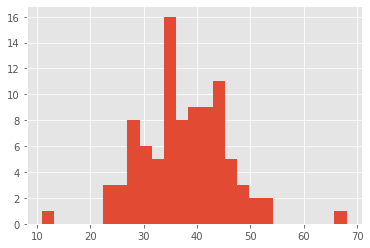

In [15]:
plt.hist(mahomes_pa, bins=25);

In [16]:
print('Sample size: ', len(mahomes_pa))
print('Mean: ', mahomes_pa.mean())
print('Median: ', np.median(mahomes_pa))
print('Standard deviation: ', mahomes_pa.std())

Sample size:  92
Mean:  37.54347826086956
Median:  37.5
Standard deviation:  8.217707608359154


In [17]:
# sampling with replacement first
xs = np.array([])
n_simulations = 10_000

for _ in range(n_simulations):
    boot_x = np.random.choice(mahomes_pa, size=len(mahomes_pa), replace=True).mean()
    xs =  np.append(xs, boot_x)

In [18]:
xs

array([38.56521739, 39.0326087 , 38.13043478, ..., 37.98913043,
       37.47826087, 36.56521739])

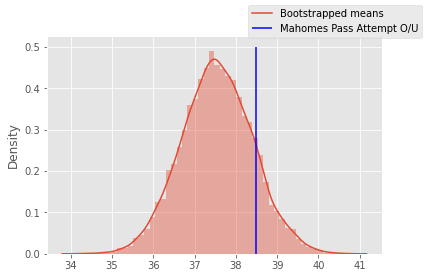

In [19]:
sns.distplot(xs);
plt.gca().vlines(x=mahomes_pa_ou, ymin=0, ymax=0.5, color='blue');
plt.gcf().legend(['Bootstrapped means', 'Mahomes Pass Attempt O/U']);

In [25]:
lower_bound, upper_bound = np.quantile(xs, 0.025), np.quantile(xs, 0.975)
lower_bound, upper_bound

(35.869565217391305, 39.27173913043478)

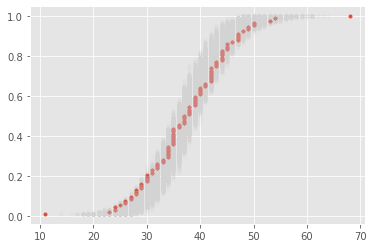

In [26]:
def ecdf(data):
  n = len(data)
  x = np.sort(data)
  y = np.arange(1, n + 1) / n
  return x, y

ecdf_x, ecdf_y = ecdf(mahomes_pa);
plt.plot(ecdf_x, ecdf_y, marker='.', linestyle='none');

mean_mahomes_pa = np.mean(mahomes_pa)

n_reps = 1000

for i in range(n_reps):
  samples = np.random.poisson(np.mean(mahomes_pa), size=len(mahomes_pa))
  theor_x, theor_y = ecdf(samples)
  plt.plot(theor_x, theor_y, marker='.', linestyle='none', alpha=0.01, color='lightgrey')

In [27]:
poisson_arr = np.random.poisson(lam=mahomes_pa.mean(), size=n_simulations)

calculated_probability = sum(poisson_arr > mahomes_pa_ou) / n_simulations
print(calculated_probability)
if calculated_probability > ip_x:
  print('Take the over')
else:
  print('Take the under')

0.4254
Take the under


In [28]:
poisson_arr_lower_bound = np.random.poisson(lam=lower_bound, size=n_simulations)
calculated_probability_lower_bound = sum(poisson_arr_lower_bound > mahomes_pa_ou) / n_simulations
calculated_probability_lower_bound

0.3257

In [29]:
poisson_arr_upper_bound = np.random.poisson(lam=upper_bound, size=n_simulations)
calculated_probability_upper_bound = sum(poisson_arr_upper_bound > mahomes_pa_ou) / n_simulations
calculated_probability_upper_bound, round(ip_x, 4)

(0.5405, 0.59)

In [32]:
hurts_pa_ou = 31.5
line = -105 # for the over

In [35]:
def implied_probability(money_line, round_n=2):
  if money_line < 0:
    return round(money_line / (money_line - 100), round_n)
  else:
    return round(1 - (money_line / (money_line + 100)), round_n)

ip_x = implied_probability(line)  
print(f'Implied probability of over {hurts_pa_ou} pass attempts for Hurts in the Super Bowl is: ', ip_x)

Implied probability of over 31.5 pass attempts for hurts in the Super Bowl is:  0.51


In [38]:
#using 2021 because he didn't play much his rookie year 
weekly_data = nfl.import_weekly_data(years=range(2021, 2023), columns=['player_name', 'attempts'])
hurts_pa = weekly_data.loc[weekly_data['player_name'] == 'J.Hurts'].attempts.values

hurts_pa

Downcasting floats.


array([35, 23, 39, 48, 37, 26, 34, 14, 17, 23, 24, 31, 26, 29, 26, 43, 32,
       31, 35, 25, 36, 25, 28, 27, 26, 25, 28, 39, 31, 37, 35, 24, 25],
      dtype=int32)

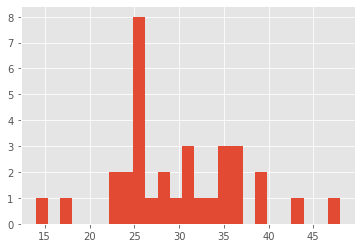

In [39]:
plt.hist(hurts_pa, bins=25);

In [40]:
print('Sample size: ', len(hurts_pa))
print('Mean: ', hurts_pa.mean())
print('Median: ', np.median(hurts_pa))
print('Standard deviation: ', hurts_pa.std())

Sample size:  33
Mean:  29.818181818181817
Median:  28.0
Standard deviation:  7.098674846265517


In [45]:
# sampling with replacement first
xs = np.array([])
n_simulations = 10_000

for _ in range(n_simulations):
    boot_x = np.random.choice(hurts_pa, size=len(hurts_pa), replace=True).mean()
    xs =  np.append(xs, boot_x)

In [46]:
xs

array([31.03030303, 29.03030303, 27.33333333, ..., 30.24242424,
       29.21212121, 30.27272727])

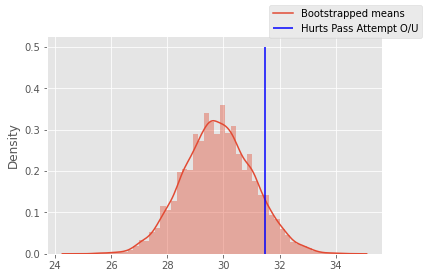

In [47]:
sns.distplot(xs);
plt.gca().vlines(x=hurts_pa_ou, ymin=0, ymax=0.5, color='blue');
plt.gcf().legend(['Bootstrapped means', 'Hurts Pass Attempt O/U']);

In [48]:
lower_bound, upper_bound = np.quantile(xs, 0.025), np.quantile(xs, 0.975)
lower_bound, upper_bound

(27.424242424242426, 32.27272727272727)

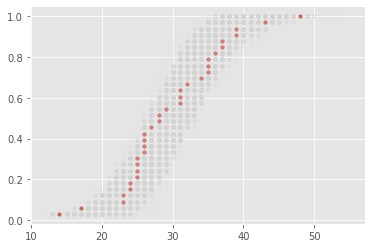

In [49]:
def ecdf(data):
  n = len(data)
  x = np.sort(data)
  y = np.arange(1, n + 1) / n
  return x, y

ecdf_x, ecdf_y = ecdf(hurts_pa);
plt.plot(ecdf_x, ecdf_y, marker='.', linestyle='none');

mean_hurts_pa = np.mean(hurts_pa)

n_reps = 1000

for i in range(n_reps):
  samples = np.random.poisson(np.mean(hurts_pa), size=len(hurts_pa))
  theor_x, theor_y = ecdf(samples)
  plt.plot(theor_x, theor_y, marker='.', linestyle='none', alpha=0.01, color='lightgrey')

In [50]:
poisson_arr = np.random.poisson(lam=hurts_pa.mean(), size=n_simulations)

calculated_probability = sum(poisson_arr > hurts_pa_ou) / n_simulations
print(calculated_probability)
if calculated_probability > ip_x:
  print('Take the over')
else:
  print('Take the under')

0.3696
Take the under


In [51]:
poisson_arr_lower_bound = np.random.poisson(lam=lower_bound, size=n_simulations)
calculated_probability_lower_bound = sum(poisson_arr_lower_bound > hurts_pa_ou) / n_simulations
calculated_probability_lower_bound

0.2208

In [53]:
poisson_arr_upper_bound = np.random.poisson(lam=upper_bound, size=n_simulations)
calculated_probability_upper_bound = sum(poisson_arr_upper_bound > hurts_pa_ou) / n_simulations
calculated_probability_upper_bound, round(ip_x, 4)

(0.5323, 0.51)

In [ ]:
#miles sanders anytime td odds 
line = -110

In [54]:
def implied_probability(money_line, round_n=2):
  if money_line < 0:
    return round(money_line / (money_line - 100), round_n)
  else:
    return round(1 - (money_line / (money_line + 100)), round_n)

ip_x = implied_probability(line)  
print(f'Implied probability of Anytime TD for Miles Sanders in the Super Bowl is: ', ip_x)

Implied probability of Anytime TD pass attempts for Miles Sanders in the Super Bowl is:  0.51


In [55]:
pbp_data = nfl.import_pbp_data(years=range(2019, 2023))


2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [57]:
sanders_tds = pbp_data.loc[pbp_data['td_player_name'] == 'M.Sanders'].touchdown.values
sanders_tds
#im stuck, not sure how to stucture the data for touchdowns. 

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)